# Deploying Various MNIST Models on Kubernetes 

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup kubeflow and seldon-core. This notebook will show various rolling deployments of the trained models

 * Single model
 * AB Test between 2 models
 * Multi-Armed Bandit over 3 models
 
### Dependencies
 
  * Tensorflow
  * grpcio package
 

# Setup

Set kubectl to use the namespace where you installed kubeflow and seldon. In the README it is kubeflow-seldon

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=kubeflow-seldon

Context "gke_seldon-deploy_europe-west1-b_cluster-1" modified.


In [2]:
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [3]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

/home/clive/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz




**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n default -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:80
```

# Deploy Single Tensorflow Model

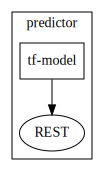

In [4]:
get_graph("../k8s_serving/serving_model.json",'r')

In [5]:
!pygmentize ../k8s_serving/serving_model.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "deployment_version": "v1",
            "project_name": "MNIST Example"
        },
        "name": "mnist-classifier",
        "predictors": [
            {
                "annotations": {
                    "predictor_version": "v1"
                },
                "componentSpec": {
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
                                "imagePullPolicy": "Always",
                                "name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
  

In [6]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" created


In [7]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[replicasAvailable:1 name:mnist-classifier-mnist-classifier replicas:1]]]

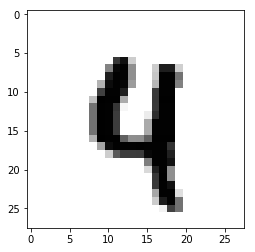

Route:{}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.91",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.09"
}


In [8]:
utils.predict_rest_mnist(mnist)

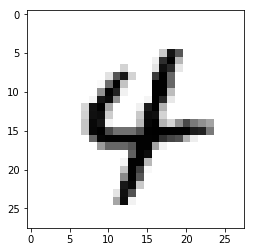

{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.97",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.01",
  "class:8": "0.00",
  "class:9": "0.01"
}


In [9]:
utils.predict_grpc_mnist(mnist)

# Start load test

In [ ]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

In [ ]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace kubeflow-seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://mnist-classifier:8000 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


# Rolling update to AB Test
 Run an AB Test between 2 models:
  * Tensorflow neural network model
  * Scikit-learn random forest.
 

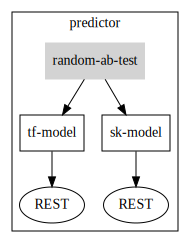

In [10]:
get_graph("../k8s_serving/ab_test_sklearn_tensorflow.json",'r')

In [11]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

In [12]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment "mnist-classifier" configured


In [15]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

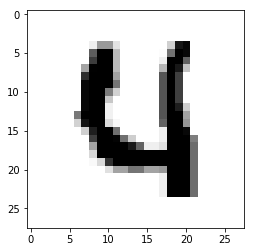

Route:{
  "random-ab-test": 0
}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.39",
  "class:3": "0.00",
  "class:4": "0.16",
  "class:5": "0.01",
  "class:6": "0.43",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.00"
}


In [16]:
utils.predict_rest_mnist(mnist)

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


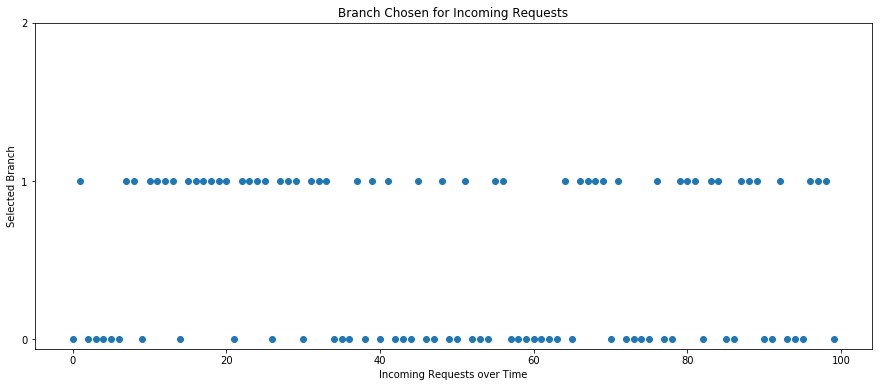

In [17]:
utils.evaluate_abtest(mnist,100)

# Rolling Update to Multi-Armed Bandit
Run a epsilon-greey multi-armed bandit over 3 models:
  * Tensorflow neural network model
  * Scikit-learn random forest model
  * R least-squares model
  

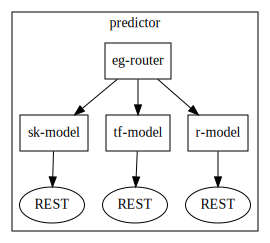

In [18]:
get_graph("../k8s_serving/epsilon_greedy_3way.json",'r')

In [19]:
!pygmentize ../k8s_serving/epsilon_greedy_3way.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

In [20]:
!kubectl apply -f ../k8s_serving/epsilon_greedy_3way.json

seldondeployment "mnist-classifier" configured


In [21]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

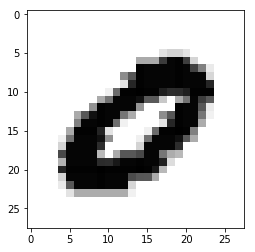

Route:{
  "eg-router": 1
}
{
  "class:0": "1.00",
  "class:1": "0.00",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.00",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.00"
}


In [22]:
utils.predict_rest_mnist(mnist)

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
[3.0, 68.0, 5.0]


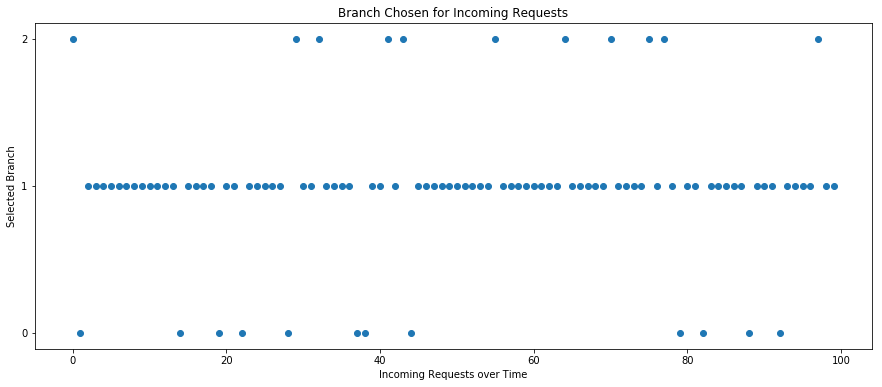

In [23]:
utils.evaluate_egreedy(mnist,100)

# Tear Down

In [ ]:
!helm delete loadtest --purge